<a href="https://colab.research.google.com/github/kaicong12/CRNN-HandWriting-Recognition/blob/main/colab/BN4101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 11.3 MB/s eta 0:00:00


In [2]:
# Tree based predictors
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import shap


# FC layer predictors
from tensorflow import keras
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# Utils package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/content/master.csv')
print(f"Original length of data is {len(data)}")

# replace infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
print(f"Final length of data is {len(data)}")

cols_to_normalize = [
    'Total time (numeric trail)', 'Total time (alphanumeric trail)', 
    'Total error (numeric path)', 'Total error (alphanumeric path)', 
    'Mean Completion Time', 'FI_score', 
    'Symbol Digit Substitution Accuracy', 'Pair Matching Accuracy'
]

# do not have to normalize categorical columns
# convert them to integer instead, resembles one-hot encoding
categorical_columns = [
    'gender', 'Maximum digits remembered correctly'
]

numerical_data = data[cols_to_normalize]
categorical_data = data[categorical_columns].astype(int)

# numerical_data = (numerical_data-numerical_data.mean())/numerical_data.std()
X = pd.concat([numerical_data, categorical_data], axis=1)
y = data['age']


# drop confusing features
# X = X.drop("FI_score", axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Original length of data is 103951
Final length of data is 83225


# Baseline Linear Regression

In [4]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Baseline RMSE
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Baseline RMSE: ", rmse)

Baseline RMSE:  7.0241088853497935


In [5]:
# # # SHAP explainer
# X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
# explainer = shap.Explainer(linear_model.predict, X100)
# shap_values = explainer(X_test)

# sample_ind = 20
# shap.plots.waterfall(shap_values[sample_ind], max_display=14)

# Tree based predictions

In [6]:
def evaluate_tree(model):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model.__class__.__name__} Baseline RMSE: ", rmse)

In [7]:
# Decision Tree
dt = DecisionTreeRegressor(random_state=0)
evaluate_tree(dt)


# Random Forest
rf = RandomForestRegressor(random_state=0)
evaluate_tree(rf)


# Boosted Tree
xgb = XGBRegressor()
evaluate_tree(xgb)

DecisionTreeRegressor Baseline RMSE:  9.81450940898287
RandomForestRegressor Baseline RMSE:  7.019004693339827
XGBRegressor Baseline RMSE:  6.8887712768891705


In [8]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

In [9]:
# # explain the tree model with SHAP
# explainer_rf = shap.Explainer(rf.predict, X100)
# shap_values_rf = explainer_rf(X_test)
# shap.plots.beeswarm(shap_values_rf)

In [10]:
# # explain the tree model with SHAP
# explainer_dt = shap.Explainer(dt.predict, X100)
# shap_values_dt = explainer_dt(X_test)
# shap.plots.beeswarm(shap_values_dt)

In [11]:
# # explain the tree model with SHAP
# explainer_xgb = shap.Explainer(xgb.predict, X100)
# shap_values_xgb = explainer_xgb(X_test)
# shap.plots.beeswarm(shap_values_xgb)

# Hyperparameter Tuning

In [12]:
def hyperparam_tuning(param_space, model):
    clf = RandomizedSearchCV(
        estimator = model, param_distributions = param_space, 
        n_iter=10, verbose=2, random_state=0, n_jobs = -1
    )
    # Fit the random search model
    clf.fit(X_train, y_train)

    print(f"Best params from {model.__class__.__name__} are ", clf.best_params_)

    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} Best RMSE = {round(rmse, 2)}.')

In [13]:
# Decision Tree random grid
params = {
    "max_depth": [1,3,5,7,9,11,12],
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
    "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    "max_leaf_nodes": [10,20,30,40,50,60,70,80,90]
}

dt = DecisionTreeRegressor(random_state = 0)
hyperparam_tuning(params, dt)


# Random Forest random grid
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]

# random_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf
# }

# rf = RandomForestRegressor()
# hyperparam_tuning(random_grid, rf)


# XGB random grid
params = { 
    'max_depth': [3, 5, 6, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10],
    "min_weight_fraction_leaf": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    # 'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
}

xgbr = XGBRegressor(seed = 0)
hyperparam_tuning(params, xgbr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params from DecisionTreeRegressor are  {'min_weight_fraction_leaf': 0.4, 'min_samples_leaf': 6, 'max_leaf_nodes': 30, 'max_depth': 9}
DecisionTreeRegressor Best RMSE = 7.3.
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[14:56:05] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_weight_fraction_leaf" } are not used.

Best params from XGBRegressor are  {'subsample': 0.7999999999999999, 'min_weight_fraction_leaf': 0.6, 'min_samples_leaf': 8, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999}
XGBRegressor Best RMSE = 6.85.


In [14]:
print("""Best params from DecisionTreeRegressor are  
    {
        'min_weight_fraction_leaf': 0.4, 
        'min_samples_leaf': 6, 
        'max_leaf_nodes': 30, 
        'max_depth': 9
    }"""
)

Best params from DecisionTreeRegressor are  
    {
        'min_weight_fraction_leaf': 0.4, 
        'min_samples_leaf': 6, 
        'max_leaf_nodes': 30, 
        'max_depth': 9
    }


# FC layers Predictions

In [15]:
fc_model = keras.Sequential()
fc_model.add(keras.layers.Dense(100, activation="relu"))
fc_model.add(keras.layers.Dense(50, activation="relu"))
fc_model.add(keras.layers.Dense(1))
fc_model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=[keras.metrics.mae]
)

In [16]:
EPOCHS = 20
BATCH = 128

early_stopping = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5)

history = fc_model.fit(
    X_train, y_train,
    batch_size=BATCH,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/20
436/436 [==============================] - 8s 6ms/step - loss: 2038.5009 - mean_absolute_error: 21.0736 - val_loss: 211.0120 - val_mean_absolute_error: 11.8755
Epoch 2/20
436/436 [==============================] - 2s 4ms/step - loss: 196.1954 - mean_absolute_error: 11.4313 - val_loss: 216.7007 - val_mean_absolute_error: 12.4102
Epoch 3/20
436/436 [==============================] - 2s 4ms/step - loss: 163.2491 - mean_absolute_error: 10.3174 - val_loss: 116.7510 - val_mean_absolute_error: 8.6471
Epoch 4/20
436/436 [==============================] - 2s 5ms/step - loss: 158.1072 - mean_absolute_error: 9.9909 - val_loss: 120.1101 - val_mean_absolute_error: 8.5196
Epoch 5/20
436/436 [==============================] - 2s 5ms/step - loss: 175.7739 - mean_absolute_error: 10.4550 - val_loss: 83.6465 - val_mean_absolute_error: 7.2441
Epoch 6/20
436/436 [==============================] - 2s 4ms/step - loss: 209.8699 - mean_absolute_error: 11.0149 - val_loss: 87.5307 - val_mean_absolute_

32/32 [==============================] - 0s 1ms/step


Exact explainer:   4%|▍         | 2/49 [00:00<?, ?it/s]

33/33 [==============================] - 0s 2ms/step


Exact explainer:   8%|▊         | 4/49 [00:24<02:01,  2.70s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  10%|█         | 5/49 [00:29<02:47,  3.80s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  12%|█▏        | 6/49 [00:34<03:09,  4.40s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  14%|█▍        | 7/49 [00:40<03:27,  4.95s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  16%|█▋        | 8/49 [00:46<03:27,  5.07s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  18%|█▊        | 9/49 [00:51<03:31,  5.28s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  20%|██        | 10/49 [00:57<03:26,  5.29s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  22%|██▏       | 11/49 [01:07<04:21,  6.88s/it]

31/31 [==============================] - 0s 2ms/step


Exact explainer:  24%|██▍       | 12/49 [01:11<03:44,  6.08s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  27%|██▋       | 13/49 [01:18<03:41,  6.15s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  29%|██▊       | 14/49 [01:23<03:27,  5.92s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  31%|███       | 15/49 [01:29<03:20,  5.90s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  33%|███▎      | 16/49 [01:34<03:09,  5.74s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  35%|███▍      | 17/49 [01:40<03:04,  5.76s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  37%|███▋      | 18/49 [01:45<02:54,  5.64s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  39%|███▉      | 19/49 [01:51<02:46,  5.56s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  41%|████      | 20/49 [01:56<02:39,  5.50s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  43%|████▎     | 21/49 [02:02<02:32,  5.44s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  45%|████▍     | 22/49 [02:12<03:07,  6.94s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  47%|████▋     | 23/49 [02:17<02:48,  6.47s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  49%|████▉     | 24/49 [02:23<02:33,  6.15s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  51%|█████     | 25/49 [02:28<02:19,  5.80s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  53%|█████▎    | 26/49 [02:33<02:10,  5.66s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  55%|█████▌    | 27/49 [02:38<02:02,  5.55s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  57%|█████▋    | 28/49 [02:49<02:27,  7.02s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  59%|█████▉    | 29/49 [02:54<02:12,  6.61s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  61%|██████    | 30/49 [03:00<01:58,  6.23s/it]

35/35 [==============================] - 0s 2ms/step


Exact explainer:  63%|██████▎   | 31/49 [03:05<01:48,  6.04s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  65%|██████▌   | 32/49 [03:12<01:43,  6.10s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  67%|██████▋   | 33/49 [03:17<01:32,  5.80s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  69%|██████▉   | 34/49 [03:23<01:28,  5.92s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  71%|███████▏  | 35/49 [03:28<01:20,  5.76s/it]

33/33 [==============================] - 0s 2ms/step


Exact explainer:  73%|███████▎  | 36/49 [03:33<01:12,  5.59s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  76%|███████▌  | 37/49 [03:39<01:06,  5.52s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  78%|███████▊  | 38/49 [03:44<01:00,  5.54s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  80%|███████▉  | 39/49 [03:55<01:10,  7.02s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  82%|████████▏ | 40/49 [04:05<01:12,  8.07s/it]

32/32 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▎ | 41/49 [04:11<00:58,  7.28s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  86%|████████▌ | 42/49 [04:16<00:45,  6.53s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer:  88%|████████▊ | 43/49 [04:21<00:36,  6.06s/it]

34/34 [==============================] - 0s 1ms/step


Exact explainer:  90%|████████▉ | 44/49 [04:31<00:36,  7.37s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  92%|█████████▏| 45/49 [04:37<00:27,  6.98s/it]

32/32 [==============================] - 0s 1ms/step


Exact explainer:  94%|█████████▍| 46/49 [04:42<00:19,  6.37s/it]

34/34 [==============================] - 0s 2ms/step


Exact explainer:  96%|█████████▌| 47/49 [04:52<00:15,  7.59s/it]

33/33 [==============================] - 0s 1ms/step


Exact explainer:  98%|█████████▊| 48/49 [04:58<00:06,  6.91s/it]

32/32 [==============================] - 0s 2ms/step


Exact explainer: 100%|██████████| 49/49 [05:03<00:00,  6.51s/it]

31/31 [==============================] - 0s 1ms/step


Exact explainer: 50it [05:08,  6.42s/it]


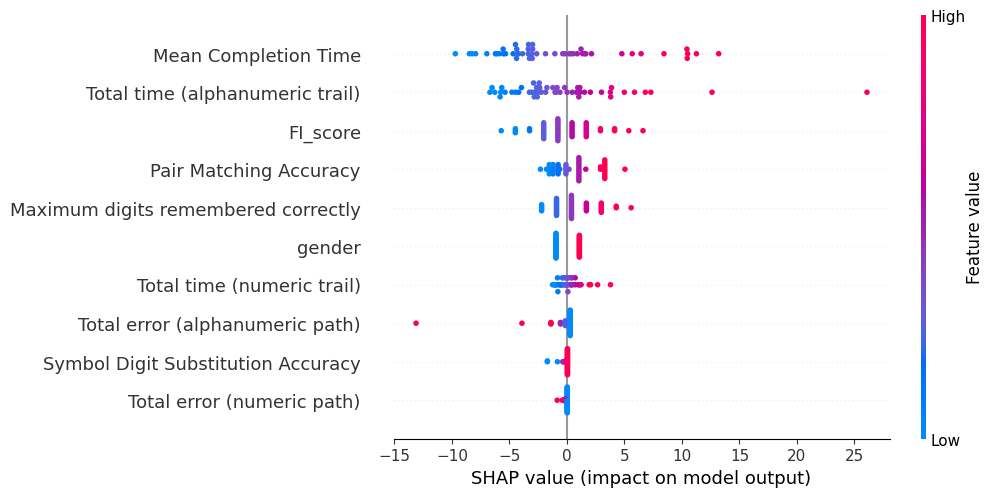

In [17]:
# explain the FC model with SHAP
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

explainer_nn = shap.Explainer(fc_model.predict, X100)
shap_values_nn = explainer_nn(X_test.iloc[51:100, :])
shap.plots.beeswarm(shap_values_nn)

# Local Interpretability

In [18]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

shap.initjs()
ex = shap.KernelExplainer(fc_model.predict, X100)
shap_values = ex.shap_values(X_test.iloc[0,:])


3194/3194 [==============================] - 6s 2ms/step


In [19]:
X_test.iloc[2,:]

Total time (numeric trail)                32.135
Total time (alphanumeric trail)           67.649
Total error (numeric path)                 0.000
Total error (alphanumeric path)            2.000
Mean Completion Time                   28685.000
FI_score                                   5.000
Symbol Digit Substitution Accuracy         1.000
Pair Matching Accuracy                     2.250
gender                                     0.000
Maximum digits remembered correctly        7.000
Name: 8966, dtype: float64